# Text analysis with spaCy and textacy

## Install required packages and models

## What is spaCy?
https://spacy.io

spaCy is a library for advanced Natural Language Processing, written in Python and Cython. spaCy utilizes convolution network models for English, German, Spanish, Portuguese, French, Italian, Dutch and multi-language NER, as well as tokenization for various other languages.

spaCy is designed for large scale text extraction, using Cython to provide increased processing speed. spaCy also supports deep learning workflows that allow connecting statistical models trained by popular machine learning libraries like TensorFlow, Keras, Scikit-learn or PyTorch.

In [1]:
import spacy
from spacy import displacy # visualization tools for spaCy

## Model: 'en_core_web_lg'

English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, context-specific token vectors, POS tags, syntactic dependency parse and named entities.

685k keys, 685k unique vectors (300 dimensions)

In [2]:
nlp = spacy.load('en_core_web_lg')

## Tokenization

spaCy automatically tokenizes text and provides several context relevant properties for each token.

Let's look at the following sentence:

**In downtown Evanston, Rhonda Smith bought 1 iPhone at 8 a.m. on October 5th because they were 30% off at BestBuy.**

In [3]:
# process document with spaCy nlp model
doc = nlp(u'In downtown Evanston, Rhonda Smith bought 1 iPhone at 8 a.m. on October 5th because they were 30% off at BestBuy.')

# get tokenized representation of sentence
tokenized = [token for token in doc]
print(tokenized)

[In, downtown, Evanston, ,, Rhonda, Smith, bought, 1, iPhone, at, 8, a.m., on, October, 5th, because, they, were, 30, %, off, at, BestBuy, .]


## Named entity recognition

In [4]:
displacy.render(doc, style='ent', jupyter=True)

In [5]:
# named entities can be use for disambiguation

doc = nlp(u"Tim Cook, CEO of Apple, has many apple trees on his property.")
displacy.render(doc, style='ent', jupyter=True)

## Token properties

In [6]:
# print properties of each token in sentence

import pandas as pd
from IPython.display import display, HTML

df = pd.DataFrame(columns='TEXT LEMMA POS TAG DEP SHAPE ALPHA ENT'.split())

for token in doc:
    tokendict = {'TEXT':token.text,
                 'LEMMA':token.lemma_,
                 'POS':token.pos_,
                 'TAG':token.tag_,
                 'DEP':token.dep_,
                 'SHAPE':token.shape_,
                 'ALPHA':token.is_alpha,
                 'ENT':token.ent_type_}
    df = df.append(tokendict, ignore_index=True)

display(HTML(df.to_html(index=False)))


TEXT,LEMMA,POS,TAG,DEP,SHAPE,ALPHA,ENT
Tim,Tim,PROPN,NNP,compound,Xxx,True,PERSON
Cook,Cook,PROPN,NNP,nsubj,Xxxx,True,PERSON
",",",",PUNCT,",",punct,",",False,
CEO,CEO,PROPN,NNP,appos,XXX,True,
of,of,ADP,IN,prep,xx,True,
Apple,Apple,PROPN,NNP,pobj,Xxxxx,True,ORG
",",",",PUNCT,",",punct,",",False,
has,have,AUX,VBZ,ROOT,xxx,True,
many,many,ADJ,JJ,amod,xxxx,True,
apple,apple,NOUN,NN,compound,xxxx,True,


## Syntactic dependency relationships

Syntactic dependencies are the grammatical relationships between words. spaCy can be used to extract this dependency information from sentences in a text. 

In [7]:
# visualization of syntactic dependency 
displacy.render(doc, style='dep', jupyter=True)

In [8]:
# syntactic dependency relationships in practice
# currency values and the nouns they refer to


TEXTS = [
    """Google just made another giant move in its Silicon Valley land grab.

The internet company spent $1 billion on a large office park near its headquarters in Mountain View, California, according to the Mercury News, and has now spent at least $2.8 billion on properties in Mountain View, Sunnyvale and San Jose over the last two years.
In this case, Google is purchasing property that it's already been leasing. The company is the main tenant of the 12 buildings that comprise the 51.8-acre Shoreline Technology Park.

Google declined to comment on its purchase.

Earlier this month, Google agreed to pay an additional $110 million for 10.5 acres for a new campus in downtown San Jose, with the possibility of buying about 11 more acres. The city will vote on the plans in early December.
It's also been a big year for Google property purchases outside of Silicon Valley.

In the first quarter, the company spent $2.4 billion to buy New York City's Chelsea Market. Chief Financial Officer Ruth Porat said that the company favors "owning rather than leasing real estate when we see good opportunities."

As for leases, Google just signed on for a massive new space in downtown San Francisco."""
]

class stop_loop(Exception): pass

def qualifier_value(money_txt):
    money_doc = nlp(str(money_txt))
    pos_list = [token.pos_ for token in money_doc]
    money_list = [token.text for token in money_doc]
    money_start = min(loc for loc, pos in enumerate(pos_list) if (pos == 'SYM' or pos == 'NUM'))
    qualifier = ' '.join(money_list[:money_start])
    value = ' '.join(money_list[money_start:])
    return qualifier, value
    

def extract_currency_relations(doc):
    # merge entities and noun chunks into one token
    spans = list(doc.ents) + list(doc.noun_chunks)
    for span in spans:
        span.merge()

    relations = []
    for money in filter(lambda w: w.ent_type_ == 'MONEY', doc):
        try:
            # syntactic relationship 1
            advcl = [w for w in money.head.children if w.dep_ == 'advcl']
            if advcl:
                for child in advcl[0].children:
                    if child.dep_ == 'dobj':
                        parse_type = 1
                        qual, val = qualifier_value(money.text)
                        relations.append((qual, val, child, parse_type))
                        raise stop_loop()
                        
            # syntactic relationship 2
            cprep = [w for w in money.children if w.dep_ == 'prep']
            if cprep:
                for child in cprep[0].children:
                    if child.dep_ == 'pobj':
                        parse_type = 2
                        qual, val = qualifier_value(money.text)
                        relations.append((qual, val, child, parse_type))
                        raise stop_loop()
            
            # syntactic relationship 3
            hprep = [w for w in money.head.children if w.dep_ == 'prep']
            if hprep:
                for child in hprep[0].children:
                    if child.dep_ == 'pobj':
                        parse_type = 3
                        qual, val = qualifier_value(money.text)
                        relations.append((qual, val, child, parse_type))
                        raise stop_loop()
                        
            # syntactic relationship 4
            if money.dep_ in ('attr', 'dobj'):
                subject = [w for w in money.head.lefts if w.dep_ == 'nsubj']
                if subject:
                    parse_type = 4
                    subject = subject[0]
                    qual, val = qualifier_value(money.text)
                    relations.append((qual, val, subject, parse_type))
                    raise stop_loop()
                    
            # syntactic relationship 5
            elif money.dep_ == 'pobj' and money.head.dep_ == 'prep':
                parse_type = 5
                qual, val = qualifier_value(money.text)
                relations.append((qual, val, money.head.head, parse_type))
                raise stop_loop()
                
        except stop_loop:
            pass
                 
    return relations

df = pd.DataFrame(columns='QUALIFIER VALUE ASSET'.split())

for text in TEXTS:
    print(text)
    #doc = nlp(unicode(text, 'utf-8'))
    doc = nlp(str(text))
    relations = extract_currency_relations(doc)
    for r0, r1, r2, r3 in relations:
        relation_dict = {'QUALIFIER':r0, 'VALUE':r1, 'ASSET':r2.text}
        #relation_dict = {'MONETARY_VALUE':r2.text, 'ASSET':r1.text}
        df = df.append(relation_dict, ignore_index=True)
        #print('{:<10}\t{}\t{}'.format(r1.text, r2.ent_type_, r2.text))
    #print('\n')

display(HTML(df.to_html(index=False)))


Google just made another giant move in its Silicon Valley land grab.

The internet company spent $1 billion on a large office park near its headquarters in Mountain View, California, according to the Mercury News, and has now spent at least $2.8 billion on properties in Mountain View, Sunnyvale and San Jose over the last two years.
In this case, Google is purchasing property that it's already been leasing. The company is the main tenant of the 12 buildings that comprise the 51.8-acre Shoreline Technology Park.

Google declined to comment on its purchase.

Earlier this month, Google agreed to pay an additional $110 million for 10.5 acres for a new campus in downtown San Jose, with the possibility of buying about 11 more acres. The city will vote on the plans in early December.
It's also been a big year for Google property purchases outside of Silicon Valley.

In the first quarter, the company spent $2.4 billion to buy New York City's Chelsea Market. Chief Financial Officer Ruth Porat sa

QUALIFIER,VALUE,ASSET
,$ 1 billion,a large office park
at least,$ 2.8 billion,properties
an additional,$ 110 million,10.5 acres
,$ 2.4 billion,New York City's Chelsea Market


In [9]:
# Convert monetary values to integer using regex substitution

import re

int_values = []
for text_value in df['VALUE']:
    if 'million' in text_value:
        money_expr = re.sub('million', '*1000000', text_value.strip())
    elif 'billion' in text_value:
        money_expr = re.sub('billion', '*1000000000', text_value.strip())
    money_expr = re.sub(r'\$', '', money_expr)
    money_int = eval(money_expr)
    int_values.append(int(money_int))
    
df = df.assign(VALUE=int_values)

display(HTML(df.to_html(index=False)))

QUALIFIER,VALUE,ASSET
,1000000000,a large office park
at least,2800000000,properties
an additional,110000000,10.5 acres
,2400000000,New York City's Chelsea Market


## textacy 
https://chartbeat-labs.github.io/textacy/index.html

textacy builds upon spaCy's framework and provides convenient functions for many advanced NLP tools. textacy also performs basic text feature counts and computes several readability measures. 

In [10]:
# perform topic model of Presidental Inaugural addresses
# download speeches from nltk

import nltk
nltk.download('inaugural')

[nltk_data] Downloading package inaugural to /home/jupyter-
[nltk_data]     schorndorfer/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [11]:
# get collect measures from Obama's inaugural address

# import the inaugural addresses
from nltk.corpus import inaugural

names = inaugural.fileids()
name = names[-1]
print(name)

filetext = inaugural.raw(fileids=name)
doc = nlp(filetext)

# print first ten lines as sample
for line in filetext.splitlines()[:10]:print(line)

2017-Trump.txt
Chief Justice Roberts, President Carter, President Clinton, President Bush, President Obama, fellow Americans, and people of the world: Thank you.

We, the citizens of America, are now joined in a great national effort to rebuild our country and restore its promise for all of our people. Together, we will determine the course of America and the world for many, many years to come. We will face challenges, we will confront hardships, but we will get the job done.

Every 4 years, we gather on these steps to carry out the orderly and peaceful transfer of power, and we are grateful to President Obama and First Lady Michelle Obama for their gracious aid throughout this transition. They have been magnificent. Thank you.

Today's ceremony, however, has very special meaning. Because today we are not merely transferring power from one administration to another or from one party to another, but we are transferring power from Washington, DC, and giving it back to you, the people.

F

In [12]:
# import textacy package

import textacy

# compute counts and readability stats
ts = textacy.TextStats(doc)

print('Unique words')
print(ts.n_unique_words)
print('-----------------')
print('Basic counts')
print(ts.basic_counts)
print('-----------------')
print('Readabiltiy stats')
print(ts.readability_stats)



Unique words
537
-----------------
Basic counts
{'n_sents': 91, 'n_words': 1468, 'n_chars': 6749, 'n_syllables': 2083, 'n_unique_words': 537, 'n_long_words': 317, 'n_monosyllable_words': 1046, 'n_polysyllable_words': 171}
-----------------
Readabiltiy stats
{'flesch_kincaid_grade_level': 7.444889061891789, 'flesch_reading_ease': 70.4190557535108, 'smog_index': 10.96019143586787, 'gunning_fog_index': 11.112147797706381, 'coleman_liau_index': 9.397201394414175, 'automated_readability_index': 8.289741967841422, 'lix': 37.72587358145941, 'gulpease_index': 61.62261580381471, 'wiener_sachtextformel': 4.546989496062521}


Text(0, 0.5, 'grade level')

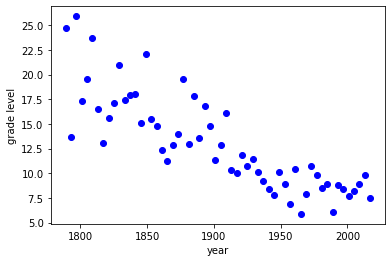

In [13]:
%matplotlib inline

# plot inaugural speech grade-level over time
import matplotlib.pyplot as pyplot

years = []
grade_lvls = []
for name in names:
    filetext = inaugural.raw(fileids=name)
    year = int(name.split('-')[0])
    years.append(year)
    
    doc = nlp(filetext)
    ts = textacy.TextStats(doc)
    grade_lvl = ts.readability_stats['flesch_kincaid_grade_level']
    grade_lvls.append(grade_lvl)

pyplot.plot(years, grade_lvls, 'bo')
pyplot.xlabel('year')
pyplot.ylabel('grade level')

In [14]:
# Use spaCy to generate list of terms from corpus of documents
import os
import textacy
from spacy.lang.en.stop_words import STOP_WORDS

# import the inaugural addresses
from nltk.corpus import inaugural

names = inaugural.fileids()
print(names)

terms_list = []

for name in names:
    filetext = inaugural.raw(fileids=name)
    doc = nlp(filetext)
    terms_list.append([token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS and token.text.isalnum()])


['1789-Washington.txt', '1793-Washington.txt', '1797-Adams.txt', '1801-Jefferson.txt', '1805-Jefferson.txt', '1809-Madison.txt', '1813-Madison.txt', '1817-Monroe.txt', '1821-Monroe.txt', '1825-Adams.txt', '1829-Jackson.txt', '1833-Jackson.txt', '1837-VanBuren.txt', '1841-Harrison.txt', '1845-Polk.txt', '1849-Taylor.txt', '1853-Pierce.txt', '1857-Buchanan.txt', '1861-Lincoln.txt', '1865-Lincoln.txt', '1869-Grant.txt', '1873-Grant.txt', '1877-Hayes.txt', '1881-Garfield.txt', '1885-Cleveland.txt', '1889-Harrison.txt', '1893-Cleveland.txt', '1897-McKinley.txt', '1901-McKinley.txt', '1905-Roosevelt.txt', '1909-Taft.txt', '1913-Wilson.txt', '1917-Wilson.txt', '1921-Harding.txt', '1925-Coolidge.txt', '1929-Hoover.txt', '1933-Roosevelt.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1945-Roosevelt.txt', '1949-Truman.txt', '1953-Eisenhower.txt', '1957-Eisenhower.txt', '1961-Kennedy.txt', '1965-Johnson.txt', '1969-Nixon.txt', '1973-Nixon.txt', '1977-Carter.txt', '1981-Reagan.txt', '1985-Reaga

## Topic modeling with spaCy and textacy

Topic models can provide a means to analyze and categorize a corpus of texts. Topics often refer to clusters of words that frequently occur together. 

In [15]:
# Use spaCy to generate list of terms from corpus of documents
import os
import textacy
from spacy.lang.en.stop_words import STOP_WORDS

# import the inaugural addresses
from nltk.corpus import inaugural

names = inaugural.fileids()
print(names)

# create list of terms from token lemmas in texts
terms_list = []

for name in names:
    filetext = inaugural.raw(fileids=name)
    doc = nlp(filetext)
    terms_list.append([token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS and token.text.isalnum()])


['1789-Washington.txt', '1793-Washington.txt', '1797-Adams.txt', '1801-Jefferson.txt', '1805-Jefferson.txt', '1809-Madison.txt', '1813-Madison.txt', '1817-Monroe.txt', '1821-Monroe.txt', '1825-Adams.txt', '1829-Jackson.txt', '1833-Jackson.txt', '1837-VanBuren.txt', '1841-Harrison.txt', '1845-Polk.txt', '1849-Taylor.txt', '1853-Pierce.txt', '1857-Buchanan.txt', '1861-Lincoln.txt', '1865-Lincoln.txt', '1869-Grant.txt', '1873-Grant.txt', '1877-Hayes.txt', '1881-Garfield.txt', '1885-Cleveland.txt', '1889-Harrison.txt', '1893-Cleveland.txt', '1897-McKinley.txt', '1901-McKinley.txt', '1905-Roosevelt.txt', '1909-Taft.txt', '1913-Wilson.txt', '1917-Wilson.txt', '1921-Harding.txt', '1925-Coolidge.txt', '1929-Hoover.txt', '1933-Roosevelt.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1945-Roosevelt.txt', '1949-Truman.txt', '1953-Eisenhower.txt', '1957-Eisenhower.txt', '1961-Kennedy.txt', '1965-Johnson.txt', '1969-Nixon.txt', '1973-Nixon.txt', '1977-Carter.txt', '1981-Reagan.txt', '1985-Reaga

======================model=================
TopicModel(n_topics=20, model=NMF)
topic 0 : Union   Government   Texas   States   revenue   power   protection   extend   Constitution   interest
topic 1 : America   new   nation   today   child   century   Americans   world   work   time
0 0.024945338475366743
1 0.09147405958079863
2 0.03716334945612288
3 0.04619126551391594
4 0.041002453178791316
5 0.04175448995225968
6 0.036661249819285924
7 0.0384848124903307
8 0.04125439656445504
9 0.04146338054090794
10 0.05547062989345874
11 0.04672817563370066
12 0.07261595393021505
13 0.049547233286547226
14 0.053544345330026645
15 0.046032836318791924
16 0.03899647189784691
17 0.05771787408183839
18 0.06625176736075494
19 0.07269991669458457


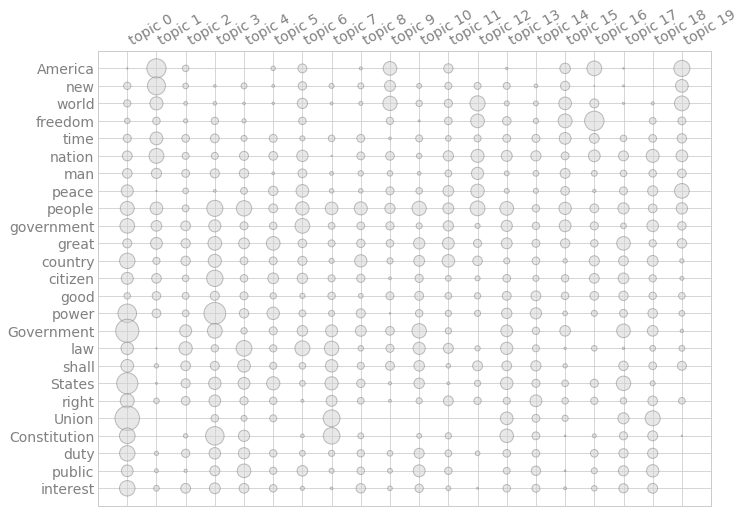

In [17]:
%matplotlib inline
import matplotlib
 
# create word vectors from speech terms
from textacy.tm import TopicModel
from textacy.vsm import Vectorizer

vectorizer = Vectorizer(tf_type='linear', apply_idf=True, idf_type='smooth')
doc_term_matrix = vectorizer.fit_transform(terms_list)

#initialize and train a topic model:
model = TopicModel('nmf', n_topics=20)
model.fit(doc_term_matrix)

print ("======================model=================")
print (model)
 
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, topics=[0,1]):
    print('topic', topic_idx, ':', '   '.join(top_terms))
    
for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
     print(i, val)
           
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, topics=-1,  n_terms=25, sort_terms_by='seriation')  
model.save('nmf-25topics_inaugural.pkl')        


## And much much more...
https://spacy.io/usage/linguistic-features